
#如何操作
1. 在Colab上運行此程式碼。
2. 每次要求上傳一張影像，執行10次，共處理10張影像。
3. 最後會儲存到Colab環境，格式為`processed_影像名稱`。

#大致流程
1. 影像上傳使用Colab的`files.upload()`選擇並上傳影像。
2. 使用OpenCV讀取並轉為灰階。
3. 表格偵測與移除，偵測水平與垂直線，將表格區域去除。
4. 用二值化與去雜訊處理，讓手寫數字更清楚。
5. 將影像放大，提高辨識準確度。
6. 用Tesseract OCR來讀取影像中的手寫數字。
7. 顯示辨識結果並將處理後的影像存檔。
""" 整體錯誤率約為80-90%且輸出會跑版

In [3]:
!apt-get update
!apt-get install -y tesseract-ocr
!pip install pytesseract


Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,315 kB]
Get:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,674 kB]
Get:13 http://archive.ubuntu.com/ubuntu jammy-upda

加註解的程式碼，不含結果

In [ ]:
import cv2  # 匯入 OpenCV 進行影像處理
import numpy as np  # 匯入 NumPy 進行數值運算
import pytesseract  # 匯入 Tesseract OCR 進行文字辨識
import matplotlib.pyplot as plt  # 匯入 Matplotlib 以顯示影像
from google.colab import files  # 匯入 Colab 上傳模組
from PIL import Image  # 匯入 PIL 進行影像處理

# **上傳影像**
for i in range(10):  # 執行 10 次，以處理 10 張影像
    uploaded = files.upload()  # 使用 Colab 讓使用者上傳影像
    photo_path = list(uploaded.keys())[0]  # 取得使用者上傳的影像檔名

    # **讀取影像**
    photo_img = cv2.imread(photo_path, cv2.IMREAD_GRAYSCALE)  # 讀取影像並轉換為灰階

    # **步驟 1: 偵測表格線**
    def detect_table(image):
        blurred = cv2.GaussianBlur(image, (3, 3), 0)  # 使用高斯模糊降低雜訊
        _, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)  # Otsu 二值化處理
        horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (100, 1))  # 設定水平方向的偵測範圍
        detected_horizontal = cv2.morphologyEx(binary, cv2.MORPH_OPEN, horizontal_kernel)  # 偵測水平線
        vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 100))  # 設定垂直方向的偵測範圍
        detected_vertical = cv2.morphologyEx(binary, cv2.MORPH_OPEN, vertical_kernel)  # 偵測垂直線
        table_mask = cv2.add(detected_horizontal, detected_vertical)  # 合併水平與垂直線
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 1))  # 設定膨脹範圍
        table_mask = cv2.dilate(table_mask, kernel, iterations=3)  # 膨脹處理，強化表格線
        return table_mask

    # **步驟 2: 偵測並移除表格**
    table_mask = detect_table(photo_img)  # 取得表格遮罩
    photo_no_table = cv2.subtract(photo_img, table_mask)  # 從原影像中移除表格線
    photo_no_table[table_mask > 0] = 255  # 確保表格區域變為白色

    # **步驟 3: 增強手寫數字**
    _, handwriting_binary = cv2.threshold(photo_no_table, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)  # 進行二值化處理

    # **步驟 4: 進一步去除雜訊與增強對比**
    kernel = np.ones((2, 2), np.uint8)  # 定義形態學運算的核
    cleaned = cv2.morphologyEx(handwriting_binary, cv2.MORPH_OPEN, kernel, iterations=1)  # 形態學開運算去除雜訊

    # **步驟 5: 放大影像，提高 OCR 辨識率**
    scale_percent = 200  # 設定縮放比例為 200%
    width = int(cleaned.shape[1] * scale_percent / 100)  # 計算新的寬度
    height = int(cleaned.shape[0] * scale_percent / 100)  # 計算新的高度
    dim = (width, height)
    resized = cv2.resize(cleaned, dim, interpolation=cv2.INTER_LINEAR)  # 使用線性插值進行影像縮放

    # **顯示處理後的影像**
    plt.figure(figsize=(12, 6))  # 設定圖片大小
    plt.subplot(1, 3, 1)
    plt.imshow(photo_img, cmap="gray")  # 顯示原始影像
    plt.title("原始影像")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(photo_no_table, cmap="gray")  # 顯示去除表格後的影像
    plt.title("去除表格後")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(resized, cmap="gray")  # 顯示增強後的影像
    plt.title("增強後影像")
    plt.axis("off")

    plt.show()

    # **步驟 6: OCR 辨識數字**
    custom_config = r'--oem 3 --psm 4 -c tessedit_char_whitelist=0123456789+- preserve_interword_spaces=1 tessedit_ocr_engine_mode=1'  # 設定 OCR 參數
    ocr_result = pytesseract.image_to_string(resized, config=custom_config)  # 執行 OCR 辨識

    # **輸出 OCR 結果**
    print(f"🔍 OCR 辨識結果 ({photo_path}):")  # 輸出辨識結果
    print(ocr_result.strip())

    # **儲存最終影像**
    processed_filename = f"processed_{photo_path}"  # 設定儲存檔案名稱
    cv2.imwrite(processed_filename, resized)  # 儲存處理後影像
    print(f"📁 處理後影像已儲存為 `{processed_filename}`")  # 輸出儲存訊息


未加註解的程式碼+結果

Saving Tphoto1.jpeg to Tphoto1.jpeg


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 22987 (\N{CJK UNIFIED IDEOGRAPH-59CB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24433 (\N{CJK UNIFIED IDEOGRAPH-5F71}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20687 (\N{CJK UNIFIED IDEOGRAPH-50CF}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21435 (\N{CJK UNIFIED IDEOGRAPH-53BB}) missing from font(s) DejaVu Sans.
  fig.canvas

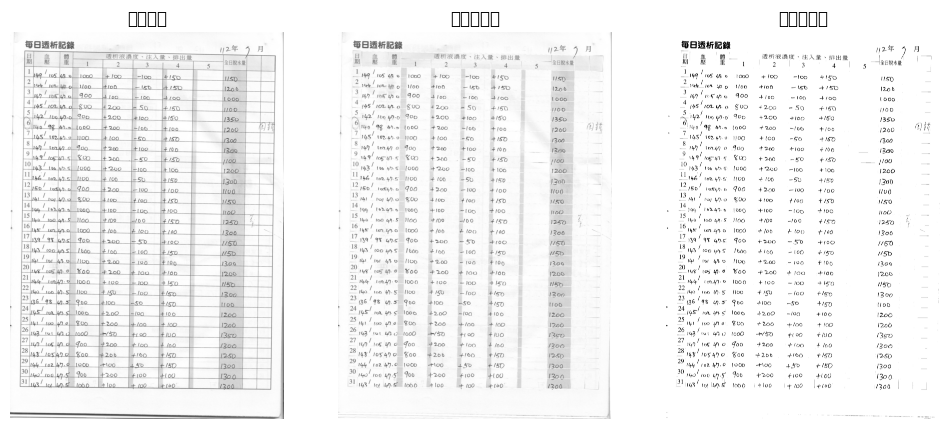

🔍 OCR 辨識結果 (Tphoto1.jpeg):
24 1-

2
14 105 4 1000 +100 -00 +10 1150
281100 +100 - +5 20
3 40 +100 100 + 00
4 145102 000+4200 -50 4150 1100
5 12 100-0 +200 +100 +150 1330 2
94 4-1000 +200 -06 +00 1200
1024490100 +100 -50 + 1300
34 1 74990 +200 +100 4100 1300
19 5-40-5+200-6 15000
10 13 4-51000 +7200-00 +100 1200
247-51100 +100 -50 +150 200
1 10549000 +200 100 +100 100
13 4 -0600 +100 100 +50
1 249-61000 +100 -100 +100 00
0404100100 1250
16 0719 00 +100 00 +100 1800
79 4260+2000 +100 - -
16 143 004 000 +100 - + 150 -
1 4081100 +200-100 +100 1300
29 00 +200 +100 +100 200
1 421000-100 -10+150- -
040+100 200-
23 126 45 +100 -50 +151 00
24 11006 +200 00 +100 1200
25 1 10000 +200 +100 +100 1200
26143 41000 +50 +00 +100 30
400 +200 100 +100 1800 7
28 00 +200+46042++160 1250
-9024 00- 450 +150 1300
30 100 0 +200 4100 +100 13200
313

13 00+0 +00 +00 1200 7
📁 處理後影像已儲存為 `processed_Tphoto1.jpeg`


Saving Tphoto2.jpeg to Tphoto2.jpeg


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 22987 (\N{CJK UNIFIED IDEOGRAPH-59CB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24433 (\N{CJK UNIFIED IDEOGRAPH-5F71}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20687 (\N{CJK UNIFIED IDEOGRAPH-50CF}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21435 (\N{CJK UNIFIED IDEOGRAPH-53BB}) missing from font(s) DejaVu Sans.
  fig.canvas

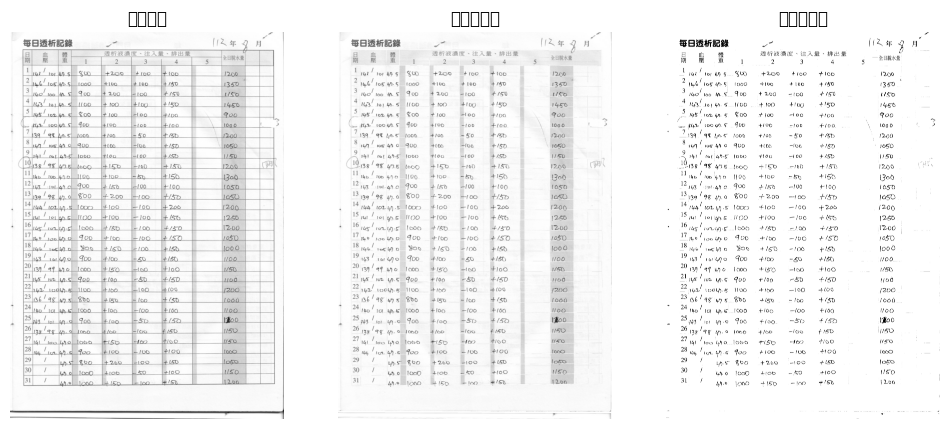

🔍 OCR 辨識結果 (Tphoto2.jpeg):
5

86
5

2
3
4

16 4

1304

2 1024

-

2100405

29 4

8

114

2 965

10

138 5

160 4

12

13101--

9399-0

14
15

4

16
7 0 4

1 10

19

41

143100-

20 139 17

21 10

1420-

23
24

25

1430 -9

26 4-0

27

1 4

28
290
30
31

74 495

4 5

6 4

400

00

4

100
00
1000
0
000
6
00
0
00
0
1
40
100
00
1100
660
0
00
100
700
0

100

7
2 3 4
+-200 +100 +100
+100 +100 +1450
+200 -100 150
4100 +100 +
+100 -1 +10
+1090 -00 +100-
+100 -450 +
+00 100 +10
+400 -100 +150
+150-100 +150
+00 -5 +1450
4156 -100 +100

+200-10044+5

+00 00 +206

+100 -100 +156
4+15-10-+50
+100 -100 150

+150-100
+100 -40 +150
+1 160 +100

+100 -0 4-150

+100 -0 +00
+150-100 +40
+100 -00 +160

1000 50

+60 -100
+150 400- 10
+100 -100 +100
42600-100-+150
+1060 -50 +100

+15-100+58

5

124 3 -

20-
10
00

0

1200
1050-
50
1200
1300
050
1050
1200
250
200
105
00
100
1750
1100
1200-
1000
1100
00
50
150
06
50-
50
12600

2
📁 處理後影像已儲存為 `processed_Tphoto2.jpeg`


Saving Tphoto3.jpeg to Tphoto3.jpeg


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 22987 (\N{CJK UNIFIED IDEOGRAPH-59CB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24433 (\N{CJK UNIFIED IDEOGRAPH-5F71}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20687 (\N{CJK UNIFIED IDEOGRAPH-50CF}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21435 (\N{CJK UNIFIED IDEOGRAPH-53BB}) missing from font(s) DejaVu Sans.
  fig.canvas

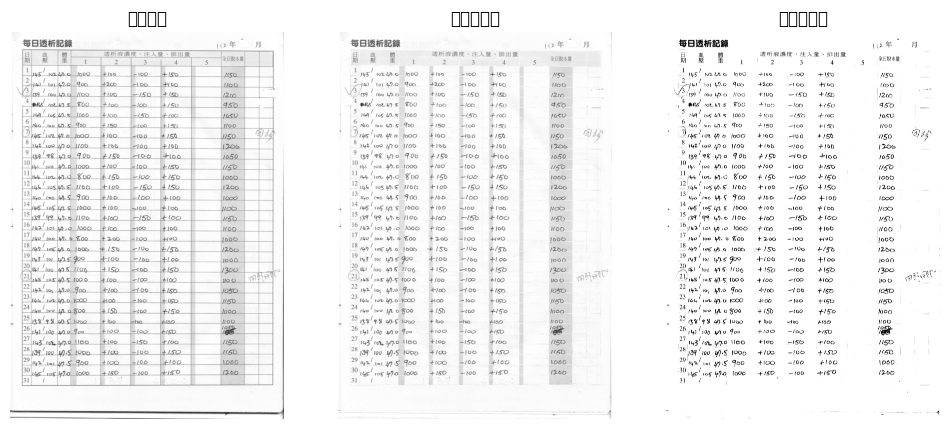

🔍 OCR 辨識結果 (Tphoto3.jpeg):
-

5

1

15

3 129

4

4

1

6

2

3

9
10

11

12
13

14
15
16
17

18
19
20

142

39

1
137
142
140
14

3

4

21
22
23
24
25
26
27
28
29
30

31

1

144

102

0

5

100

4

1

0420
10

105

0
0

-
4

40

0

-

101

-

0

-

1

100

00
00
1000
00

100
100

0
100

00

1106

900
000
10
1
00

10

4
15

1954951000

010

700

493 1

4

10 0

431

00-

134

1 -

9-0

0
000

35

+50 -00

2 30 4
+1 100 +150
+200 - 0 +1
+100 -150+10
+100 -100 +4150
+100 -150 +100
+150 00 +150
+ 60-100 +150
+100-109+100
-150-90 +100
+100 -100 150
150 -00+150
+100-1504150
+1006 -00 +100
+100 100 +06
+100 -50+00
+1 -100 +100
+200-00

-+150-100 15
+10-00+100
4+158-00+150
+ 100 -00 +100
+00 -00 +1450
+100 -60 +150
+150 -0 4+150
+ -00
+100 -00 450
+109-50 100
+100-00+450

4100--100-100

+150

5

24

2

0

200
950

1050

1206

1050
0
1000

0
1000

-4200-

12

1000-
1300

5

1000

1060
200-
📁 處理後影像已儲存為 `processed_Tphoto3.jpeg`


Saving Tphoto4.jpeg to Tphoto4.jpeg


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 22987 (\N{CJK UNIFIED IDEOGRAPH-59CB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24433 (\N{CJK UNIFIED IDEOGRAPH-5F71}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20687 (\N{CJK UNIFIED IDEOGRAPH-50CF}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21435 (\N{CJK UNIFIED IDEOGRAPH-53BB}) missing from font(s) DejaVu Sans.
  fig.canvas

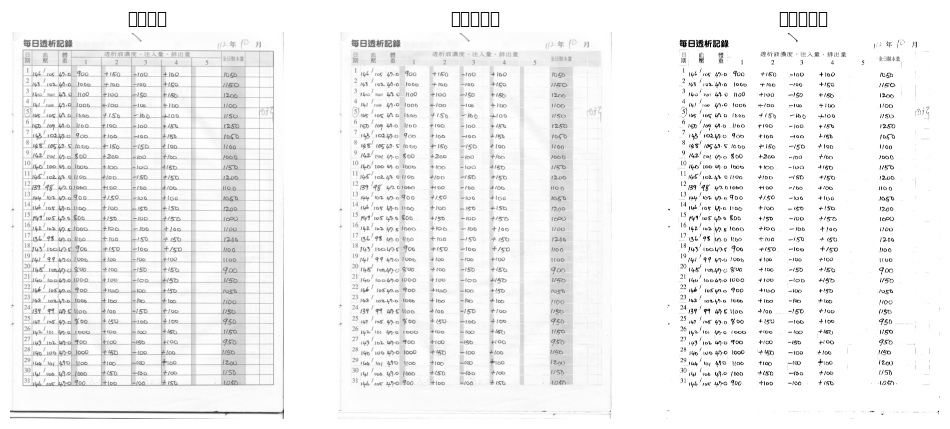

🔍 OCR 辨識結果 (Tphoto4.jpeg):
1

146 106 4-0
2 143 -0 00
3 11 40
4

4100-01006
5 6
6 1 100 440

7
143

8
110547-81

142 8 00

106100

102

1510 01100

12 401060

13 --00

14 -0106

15 000

16 142 12 1900
17 146

18 103 00
19 9701006

0 1 -090

21

1000

22 040 0-

23 1-2 024-01000

24

-13990

29149 450400

26-

110 47-0

27 143 -000

28 1106 00
29
30

31

00

1000600-

16 10 - 700

2 3 4
+180-100-+100
+10 100 +
+100 -140 +10
+100 -1060 +16

4 - 100

+100 00+8

15-150+100

+200-+-100 +0
100-10060
00--15
-0++2+106

4150-100 +100

+100 -0 +150
+150-00
-100 +1
+00-50+4760
+150-0+50
400 -100 +100

+100--150+1
+100 100 4150

+10 100 +10
-+60 9
+00--150 +0
+150 -100 +100
+100160
+100 -150 +

+5 00 +100

+100 00 +160
+50 -60 106

+0-100-1

+
2

100

1200
1
-
1250
100
10
1000
-
1200

1

1200

100

1200
0

50

105
1150

50
50
1200
5-

040-
📁 處理後影像已儲存為 `processed_Tphoto4.jpeg`


Saving Tphoto5.jpeg to Tphoto5.jpeg


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 22987 (\N{CJK UNIFIED IDEOGRAPH-59CB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24433 (\N{CJK UNIFIED IDEOGRAPH-5F71}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20687 (\N{CJK UNIFIED IDEOGRAPH-50CF}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21435 (\N{CJK UNIFIED IDEOGRAPH-53BB}) missing from font(s) DejaVu Sans.
  fig.canvas

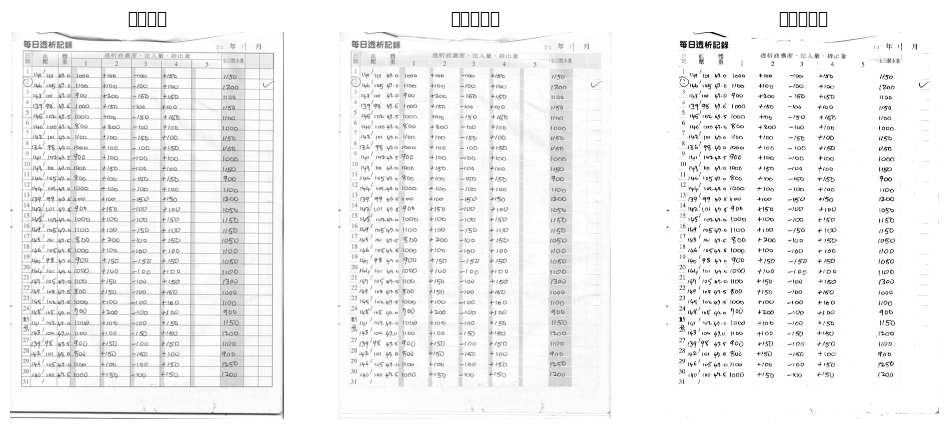

🔍 OCR 辨識結果 (Tphoto5.jpeg):
2 314 5

100 + 0 +150 -
4-61 +100 -100 100 1200
42-00 +200 160 15
2 1394 10034780 -100 4-100 150
46 100+10- 10 8
6 10 1002-4009-4200100 + 00
12 0 +100 5 +100 0-
26 71401000 +100 -100 +150 7 0

4 74- 5 0 +1090 -10 +100 - 1000
10 1 42 000 +150 -0 +100 1
52038+10 1 150 700
40100010-100100 - 1100
+100 -50 +50 1200 -
4 70+10--1004100
15 15 1000 +00 -100 +150 7 0
164- 0+100--501 50
17 13 -0 +2004- +150 050
18 6 00+1100 -160 +100
1998 +150-50 +150 100-
20 1 100100-10100 1-
2 0 - 1 +150 -100 +150 300
22 09-500 5 -100 +160 1000
23 1 51009 +100 -100 +100 1100
24 0 100 +200 100 +00 400
85 6 1-0100 +100 -100 +58 250
143 0 49 0 00 +100 -15 +160 200
27 39 9 50 +180-100+780
28 42101 000 +150 -710 100 40
1465-010100 250
391000 4100 +150 00 +150 1200
310

- -
📁 處理後影像已儲存為 `processed_Tphoto5.jpeg`


Saving Tphoto6.jpeg to Tphoto6.jpeg


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 22987 (\N{CJK UNIFIED IDEOGRAPH-59CB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24433 (\N{CJK UNIFIED IDEOGRAPH-5F71}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20687 (\N{CJK UNIFIED IDEOGRAPH-50CF}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21435 (\N{CJK UNIFIED IDEOGRAPH-53BB}) missing from font(s) DejaVu Sans.
  fig.canvas

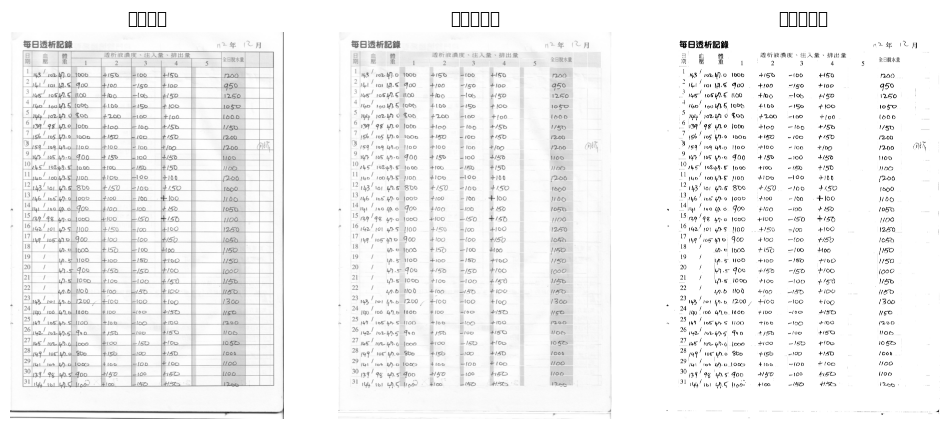

🔍 OCR 辨識結果 (Tphoto6.jpeg):
5 4

-2
163 12 0 1006 +156 -00 +150 7200
- 080+700 150 950
1008+0 50 1260
+ 4 9096 100 - +10 0
02 0 200-100 +100 100
81399001000
56108 -01600 4150-100 5 1200 7
3 154 104-1100 +100 -100 +100 120
2 5-00 +150 -100 +50 10 -
10 18249-57100 +100 -50 +150 - 100-
10 100 +100 -90 +100 200
130+150-100--150 1600
15 1 -0000 4100 -100-00 100
60 60 +100 100 +150 - 1050
941000+100050 00
16 12 -5100+50 -00 +00 1250-
90+100-004150
819001100 150
0+100 -150 100 1150
20 04150 -50 100 1000
-51000+100-100 +150 - 15
22 9-60 +100-1457 1 5
23 14 11 - 1200 +100 100 +100 1400

2 1100 4161000 +100 - -100 +150 110
25 164 10 +1 - +0 - 1200
26 4+50--100 150 0
27 600+100 -160+0 10 -
20 149 00 +150 100 +1450 - 1000
29 -010 + -100+100 00
3039+150-100 0 -
-
📁 處理後影像已儲存為 `processed_Tphoto6.jpeg`


Saving Tphoto7.jpeg to Tphoto7.jpeg


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 22987 (\N{CJK UNIFIED IDEOGRAPH-59CB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24433 (\N{CJK UNIFIED IDEOGRAPH-5F71}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20687 (\N{CJK UNIFIED IDEOGRAPH-50CF}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21435 (\N{CJK UNIFIED IDEOGRAPH-53BB}) missing from font(s) DejaVu Sans.
  fig.canvas

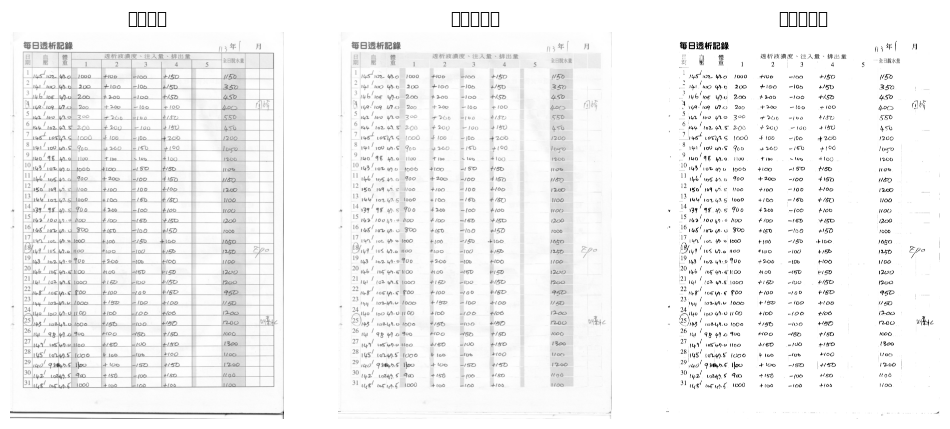

🔍 OCR 辨識結果 (Tphoto7.jpeg):
3

13 327 -
-1 23 4 5
1 1000 100 -100 +150 1740

- 1 6200 +100 -106 +750 340

3 10 200 +200 -100 +10 50
149 0 200 +200 -60 100 40
142 703 4260 100 50 550

6 14 2200 + 200 7100 +150
51000+100 -100 +200 1200

4 -0 +08-160 +00 05

- 048 01000 200

10 143 101606 +100 -50+50 1

4 1054 70 +200 -00 4150

160 1044 00 +100 100 +10 1200
10247510004100-16 0

4 139 9 700 +200 100 +100
142100 11-20 100 60 1200

16 1810 +0- -00 150 1000
100-10+ 650
14 0 46 100 -100 +156 1240
1 43 -010 +2060 -06 0-
20 10-1100 +00 -0 150 1200
21 1 0 1000 15 -00150 1200

22 -00 100 -100 50 -
23 000 + 15 - 00 +00 1750
4 160-44-01100 +100 -00 6 12-002

2545 24100 +50 -00 +5 2-

26 9200 100 760 +150 1000

27 -0100 +60 2100 150 300

28 15 951000+ -0 +100 0
290-50 400-150 4150 1200

302 02 +5--100 +0 00
100+100 100 4108 1100
📁 處理後影像已儲存為 `processed_Tphoto7.jpeg`


Saving Tphoto8.jpeg to Tphoto8.jpeg


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 22987 (\N{CJK UNIFIED IDEOGRAPH-59CB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24433 (\N{CJK UNIFIED IDEOGRAPH-5F71}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20687 (\N{CJK UNIFIED IDEOGRAPH-50CF}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21435 (\N{CJK UNIFIED IDEOGRAPH-53BB}) missing from font(s) DejaVu Sans.
  fig.canvas

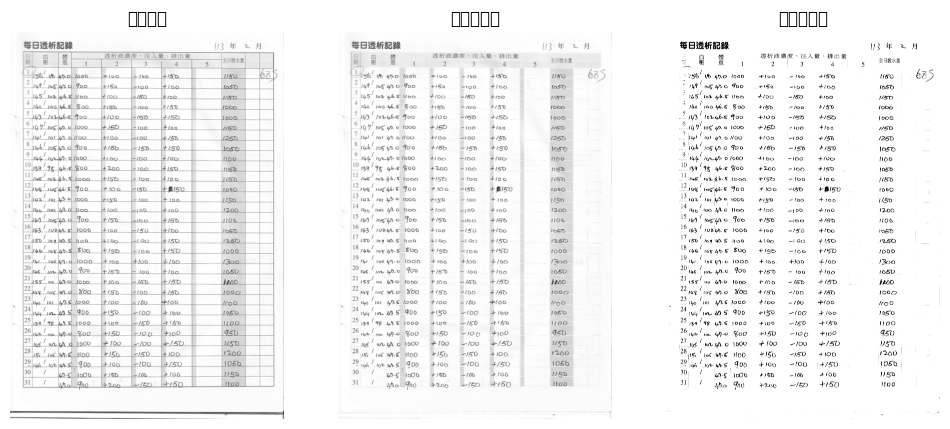

🔍 OCR 辨識結果 (Tphoto8.jpeg):
32-

16 0 -01000 +0-10 +5 5
7450149-010 - 7
49 14 +150 -10 +1 56
46 0 +100 -0 +100
- 180 008+180 -1 +50

23 10246- +100 -80 41450- - 1000 -

14901000 +50 7100 +0 50 -

26 +100 100 1250 -

3 1 0- +166 -15 +150 1040

4- 61000 +100 -100 +100 -

1029 9 200-10041450 1050

24651 ++1 -0 +100 -

2 4- +100 -0 + 50 1000

3 12 1000 +10 -100 +100 - 0

4 00 +100 -00 + 10 12-00

+50-0+460 106

16 12 124 009 +100 -150 +100 - 16

1 69 90 -0 + 5 25

18 -580 15- +30 - 1000

1 10-1000 +0 +100 +-160- 80

20 70 + 150 -100 1060

71 155 - 000 +150 00

2 14 0+755 -100 +40 1000

346 8 000 -1060 +-00 0

74 8 5400 +150 -100+100 1050

25 139 50 +00 10 +10

26 -0 +150 100 +100 0-

27000+100-+50

8 150-50+100 200-

29 0 900+100 100 4+750 1080

300 50

51 0 0 200650 +450
📁 處理後影像已儲存為 `processed_Tphoto8.jpeg`


Saving Tphoto9.jpeg to Tphoto9.jpeg


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 22987 (\N{CJK UNIFIED IDEOGRAPH-59CB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24433 (\N{CJK UNIFIED IDEOGRAPH-5F71}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20687 (\N{CJK UNIFIED IDEOGRAPH-50CF}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21435 (\N{CJK UNIFIED IDEOGRAPH-53BB}) missing from font(s) DejaVu Sans.
  fig.canvas

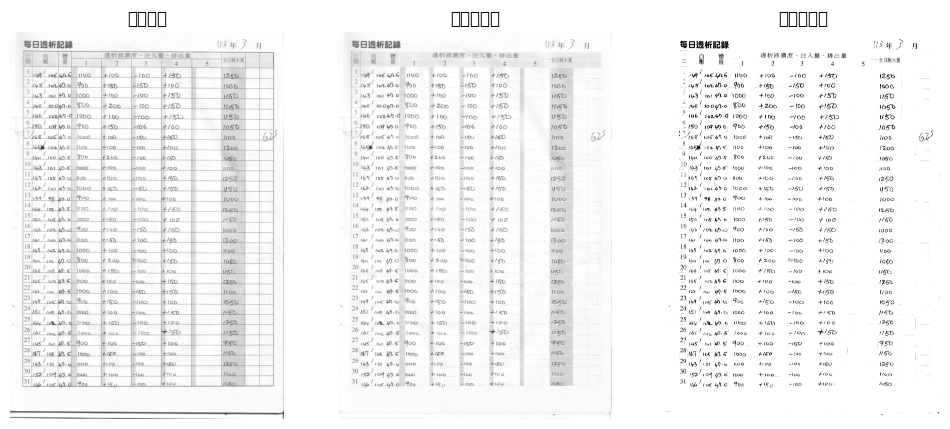

🔍 OCR 辨識結果 (Tphoto9.jpeg):
37

2 +0+
-81 2 3 45
1 1+100 -160+450 1266
10247-070 +1-10 +100 10
143 4 0 +60 -100+750 0 -
0 10049-000+4+200100- +150 1086
16 10247-91000+100 106 4 50 -
+50-10000 1050
1610 0+10 -10 +50 -
8 10 +100- -00 +100 3200
7 10 1 00 +200 100 75- - 1080-
361 1000 +100 00 100 10-
040 +100 -106 -60 1250-
127 3
14240+16 -160 4150 50
13 134 4- +100 -20 100
14 10+100-00 1260
1 1000 45 7008 100- 1480
16 - 50 150 1000
0 4-21100 +150 -100 +15 - 300
18 13 440 +100 -00 +1 1 -
1 19 0 200 10 1060
20 10-49-00 50 00 +120 56
4 102496 100 -100 4150 12506
2 142 0 5 60 +100 -0 4150 10
2349 - 0 -100 +100 0 -
2 11 42-1000 +100 -06 5
25 144 - 4150 00 400 2500
105000100--100 -
27 15+100 -150 +0-- 950
76 0 16 0 10050 0 0
29 2 49 100 4100 -100 150 - 24570 -
30 152104 44 1000 +- 00 -
31 106 00 41 -1009--100 1050
📁 處理後影像已儲存為 `processed_Tphoto9.jpeg`


Saving Tphoto10.jpeg to Tphoto10.jpeg


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 22987 (\N{CJK UNIFIED IDEOGRAPH-59CB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24433 (\N{CJK UNIFIED IDEOGRAPH-5F71}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20687 (\N{CJK UNIFIED IDEOGRAPH-50CF}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21435 (\N{CJK UNIFIED IDEOGRAPH-53BB}) missing from font(s) DejaVu Sans.
  fig.canvas

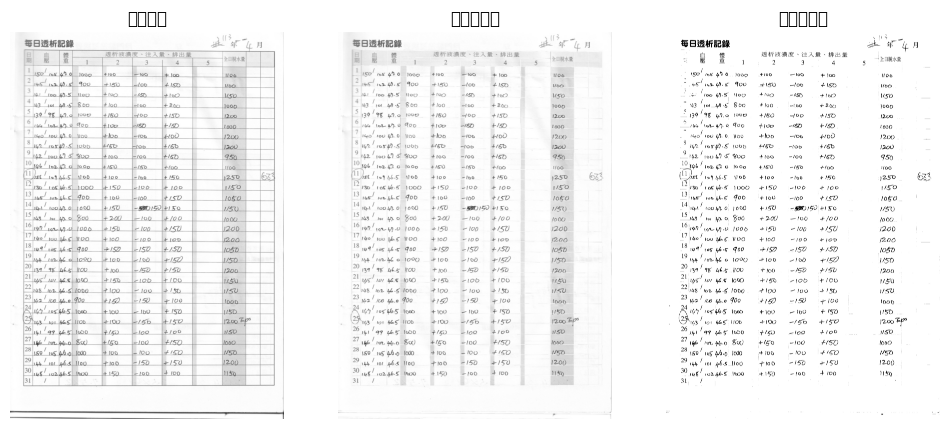

🔍 OCR 辨識結果 (Tphoto10.jpeg):
1

-

- 4

163

1395421000

4
4

2 2
1016

- 1

-

84290

4-8

49-5

2
00

0

10040

1-006

0

02420000

500

13

14

16

046-5 000

26 00

01000

4 0 000

1000

0

18
19
20

0-1000

16-00

1399

218
198
22
23

24

2

143

26 1

27

1011000

6-1000
1000 00
1054-6 100

146591100
976-500

28
8

29
30

31

16

104-6-01000
1 26 500

7

10246-880

2 30 4
+100 - +100
+1501
+10 -40
100 100 +200
+50 100 +
+100 -10 +750-
+ -10 4100
60-0084760
+10 100 1
4150 -150 +00
+100 -160 +150

+150 -190 +100-
100 +1

4150-48150+150-
+20000+00
+150 -100+7650

+100 -100 +100

+1580-10+780
+100100 +150
0-40+150
+150-100+100
100 -100 +150
+150 -150 4 00

+100 -60 + 1
+100 -150 +150

+0 -100 +00
+150 -100 450

+100-10004160
+100-50+160
+150-100+4100

5

2

1
00-
50
000
1900
1200
200
50
100
150-
1080
1150
1000
1200
1200
1050
150
1200
1750
150
200
5
100
50
1200

3
📁 處理後影像已儲存為 `processed_Tphoto10.jpeg`


In [4]:
import cv2
import numpy as np
import pytesseract
import matplotlib.pyplot as plt
from google.colab import files
from PIL import Image

for i in range(10):
    uploaded = files.upload()
    photo_path = list(uploaded.keys())[0]

    photo_img = cv2.imread(photo_path, cv2.IMREAD_GRAYSCALE)

    def detect_table(image):
        blurred = cv2.GaussianBlur(image, (3, 3), 0)
        _, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
        horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (100, 1))
        detected_horizontal = cv2.morphologyEx(binary, cv2.MORPH_OPEN, horizontal_kernel)
        vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 100))
        detected_vertical = cv2.morphologyEx(binary, cv2.MORPH_OPEN, vertical_kernel)
        table_mask = cv2.add(detected_horizontal, detected_vertical)
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 1))
        table_mask = cv2.dilate(table_mask, kernel, iterations=3)
        return table_mask
    table_mask = detect_table(photo_img)
    photo_no_table = cv2.subtract(photo_img, table_mask)
    photo_no_table[table_mask > 0] = 255
    _, handwriting_binary = cv2.threshold(photo_no_table, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    kernel = np.ones((2, 2), np.uint8)
    cleaned = cv2.morphologyEx(handwriting_binary, cv2.MORPH_OPEN, kernel, iterations=1)
    scale_percent = 200
    width = int(cleaned.shape[1] * scale_percent / 100)
    height = int(cleaned.shape[0] * scale_percent / 100)
    dim = (width, height)
    resized = cv2.resize(cleaned, dim, interpolation=cv2.INTER_LINEAR)
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(photo_img, cmap="gray")
    plt.title("原始影像")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(photo_no_table, cmap="gray")
    plt.title("去除表格後")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(resized, cmap="gray")
    plt.title("增強後影像")
    plt.axis("off")

    plt.show()
    custom_config = r'--oem 3 --psm 4 -c tessedit_char_whitelist=0123456789+- preserve_interword_spaces=1 tessedit_ocr_engine_mode=1'
    ocr_result = pytesseract.image_to_string(resized, config=custom_config)
    print(f"🔍 OCR 辨識結果 ({photo_path}):")
    print(ocr_result.strip())
    processed_filename = f"processed_{photo_path}"
    cv2.imwrite(processed_filename, resized)
    print(f"📁 處理後影像已儲存為 `{processed_filename}`")

刪表格測試

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 28165 (\N{CJK UNIFIED IDEOGRAPH-6E05}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 26224 (\N{CJK UNIFIED IDEOGRAPH-6670}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 29256 (\N{CJK UNIFIED IDEOGRAPH-7248}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 34920 (\N{CJK UNIFIED IDEOGRAPH-8868}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 26684 (\N{CJK UNIFIED IDEOGRAPH-683C}) missing from font(s) DejaVu Sans.
  fig.canvas

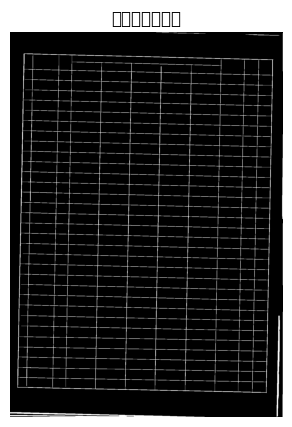

最終清晰版表格影像已儲存為 cleaned_empty.jpg


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 讀取 empty.jpg
empty_path = "photo1.jpg"
empty_img = cv2.imread(empty_path, cv2.IMREAD_GRAYSCALE)

if empty_img is None:
    raise FileNotFoundError("找不到 empty.jpg，請確認檔案存在")

# 1. **使用自適應二值化來強化表格**
binary = cv2.adaptiveThreshold(empty_img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 15, 5)

# 2. **提取水平線**
horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (40, 1))  # 長條水平線
horizontal_lines = cv2.morphologyEx(binary, cv2.MORPH_OPEN, horizontal_kernel, iterations=1)

# 3. **提取垂直線**
vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 40))  # 長條垂直線
vertical_lines = cv2.morphologyEx(binary, cv2.MORPH_OPEN, vertical_kernel, iterations=1)

# 4. **合併水平與垂直線**
table_mask = cv2.bitwise_or(horizontal_lines, vertical_lines)  # 改用 bitwise_or 確保線條清晰

# 5. **補全缺失線條 (防止線條破碎)**
table_mask = cv2.morphologyEx(table_mask, cv2.MORPH_CLOSE, np.ones((2, 2), np.uint8), iterations=1)

# 6. **最終二值化**
_, table_mask = cv2.threshold(table_mask, 50, 255, cv2.THRESH_BINARY)

# 顯示結果
plt.figure(figsize=(10, 5))
plt.imshow(table_mask, cmap="gray")
plt.title("清晰版表格影像")
plt.axis("off")
plt.show()

# 儲存結果
cv2.imwrite("cleaned_photo1.jpg", table_mask)
print("最終清晰版表格影像已儲存為 cleaned_photo1.jpg")


step1 去除表格

Saving tester3.jpeg to tester3 (1).jpeg


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 22987 (\N{CJK UNIFIED IDEOGRAPH-59CB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24433 (\N{CJK UNIFIED IDEOGRAPH-5F71}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20687 (\N{CJK UNIFIED IDEOGRAPH-50CF}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 34920 (\N{CJK UNIFIED IDEOGRAPH-8868}) missing from font(s) DejaVu Sans.
  fig.canvas

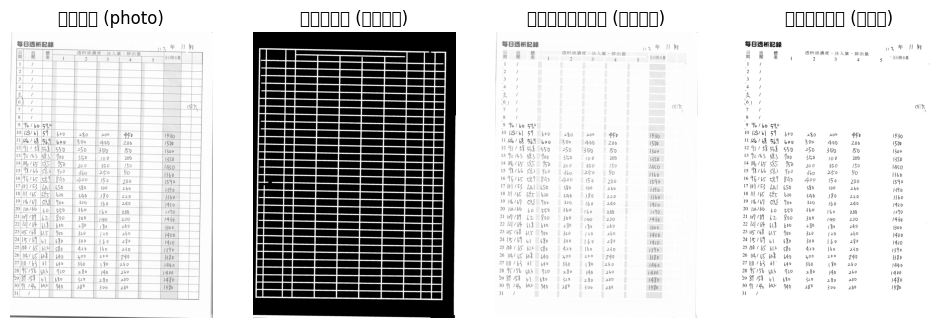

🔍 OCR 辨識結果：
21
..

1 4 3 4 5 7
2

3
4

64
7
8
9652

1023651 20 20 45 1730
1127 30 200 00
24550250-3 300
132160 56 200 380
145 360 50 450
1566 0 3 250 50
1450 540
1710153.0 330 0 260 1390
186520 3480220 360
966 320 0 240 420
202664 30 0 2 210
2173420 300 40 220 460
22127-280 300
2328 320 20 2 400
2416140 300 0 20 1420
25006510 420 60 230 340
26-660400 380
27107644 360 90-26 440
28457560 280 4 2 400
2934480 520 20 200 450

304 280 300 20 5
31
📁 最終手寫數字影像已儲存為 `handwriting.jpg`


In [6]:
import cv2
import numpy as np
import pytesseract
import matplotlib.pyplot as plt

# **上傳影像**
from google.colab import files
uploaded = files.upload()
photo_path = list(uploaded.keys())[0]  # 取得上傳的檔案名稱

# **讀取影像**
photo_img = cv2.imread(photo_path, cv2.IMREAD_GRAYSCALE)

# **步驟 1: 偵測表格線**
def detect_table(image):
    """偵測影像中的表格線，輸出表格遮罩"""
    blurred = cv2.GaussianBlur(image, (3, 3), 0)  # **降低模糊效果**

    # **Otsu 二值化**
    _, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # **偵測水平方向的表格線 (適中範圍)**
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (100, 1))
    detected_horizontal = cv2.morphologyEx(binary, cv2.MORPH_OPEN, horizontal_kernel)

    # **偵測垂直方向的表格線 (適中範圍)**
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 100))
    detected_vertical = cv2.morphologyEx(binary, cv2.MORPH_OPEN, vertical_kernel)

    # **合併水平與垂直線**
    table_mask = cv2.add(detected_horizontal, detected_vertical)

    # **適度膨脹去除殘留表格線**
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    table_mask = cv2.dilate(table_mask, kernel, iterations=3)  # **減少膨脹範圍**

    return table_mask

# **步驟 2: 偵測並移除表格**
table_mask = detect_table(photo_img)

# **步驟 3: 讓表格區域變成白色**
photo_no_table = cv2.subtract(photo_img, table_mask)
photo_no_table[table_mask > 0] = 255  # **確保表格區域變白色**

# **步驟 4: 增強手寫數字**
_, handwriting_binary = cv2.threshold(photo_no_table, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# **步驟 5: OCR 辨識數字**
config = "--psm 6 outputbase digits"
ocr_result = pytesseract.image_to_string(handwriting_binary, config=config)

# **顯示影像處理結果**
plt.figure(figsize=(12, 6))

plt.subplot(1, 4, 1)
plt.imshow(photo_img, cmap="gray")
plt.title("原始影像 (photo)")
plt.axis("off")

plt.subplot(1, 4, 2)
plt.imshow(table_mask, cmap="gray")
plt.title("表格線偵測 (適中大小)")
plt.axis("off")

plt.subplot(1, 4, 3)
plt.imshow(photo_no_table, cmap="gray")
plt.title("去除表格後的影像 (表格變白)")
plt.axis("off")

plt.subplot(1, 4, 4)
plt.imshow(handwriting_binary, cmap="gray")
plt.title("最終手寫數字 (純數字)")
plt.axis("off")

plt.show()

# **輸出 OCR 結果**
print("🔍 OCR 辨識結果：")
print(ocr_result.strip())

# **儲存處理後的影像**
cv2.imwrite("handwriting.jpg", handwriting_binary)
print("📁 最終手寫數字影像已儲存為 `handwriting.jpg`")


step2 辨識數字

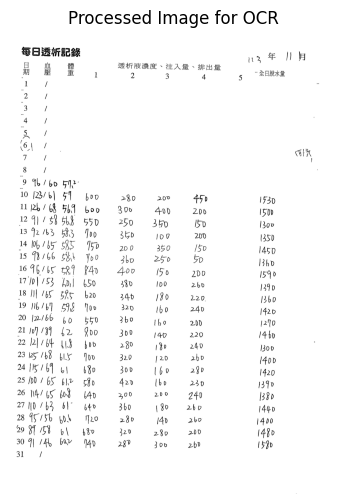

OCR 識別結果（保留數字與空白）：
3
8 - -2
1

2

3
4

5

7
8
94

10-23657 20 200 45 1530
1126768544300 4 200 500
41852036 300

13-42164 26 10 200 350
1458 200 360 40
1566 30250 50
1440015 200 540
17105350 340 0 26 290
18-765220 244 30 220 360
1916698 320 60 240 420
202664 30 10 20
212030020 40
2227 15 240 10 240 1300
23 2548 10 320 20 20 400
24161 300 60 230 1420
250765 42 0 230 340
2654-00200 39
27076364 360 30-260 1440
289075620 280 40 260 1400
2 145
309 2 3002 5
31



In [22]:
import cv2
import pytesseract
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# 讀取圖片
image_path = "handwriting.jpg"
image = cv2.imread(image_path)

# 轉換為灰階
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# 去除雜訊（高斯模糊）
gray = cv2.GaussianBlur(gray, (3, 3), 0)

# 自適應二值化（提高數字對比度）
thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

# 形態學處理 (去除小雜訊 & 增強數字邊緣)
kernel = np.ones((2, 2), np.uint8)
cleaned = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)

# 放大圖片，提高辨識率
scale_percent = 200  # 放大 2 倍
width = int(cleaned.shape[1] * scale_percent / 100)
height = int(cleaned.shape[0] * scale_percent / 100)
dim = (width, height)
resized = cv2.resize(cleaned, dim, interpolation=cv2.INTER_LINEAR)

# 顯示處理後的圖片
plt.figure(figsize=(10, 6))
plt.imshow(resized, cmap="gray")
plt.title("Processed Image for OCR")
plt.axis("off")
plt.show()

# OCR 設定（只辨識數字 & 保留空格）
custom_config = r'--oem 3 --psm 6 -c tessedit_char_whitelist=0123456789+- preserve_interword_spaces=1'

# 進行 OCR 辨識
text = pytesseract.image_to_string(resized, config=custom_config)

# 輸出結果
print("OCR 識別結果（保留數字與空白）：")
print(text)


step3 優化

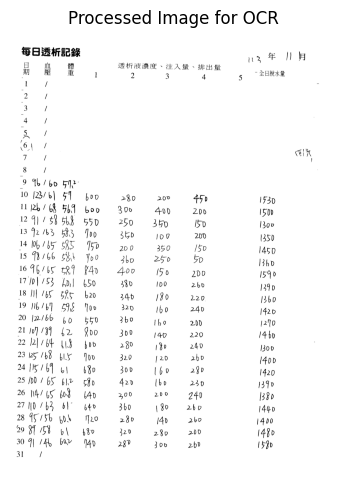

OCR 識別結果（保留數字間空白）：
124

- -
2

3

40

6
7
8

965

102657 240 200 +50 1730
20603002 0
4150250 300
132 3600 200 350
145 360 0 450
1566 3 20 50
16457655 200 540
17078350 330 0 26 129
18-65220 24 30 220 36
19-69 320 60 240 420
20266 30 6 1210
2103420 300 40 220 4
2221641 20 10 240 1300
238 320 20 20 40
241610 200 60 20 1420
2500165 420 0 230 340
26-4002 80
2776444 360 10-26 440
28 4 00 280 40 20 400
29 320 280 200 450
309 280 300-2 53

31



In [16]:
import cv2
import pytesseract
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# 讀取圖片
image_path = "handwriting.jpg"
image = cv2.imread(image_path)

# 轉換為灰階
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# 降噪（高斯模糊）
gray = cv2.GaussianBlur(gray, (3, 3), 0)

# 二值化（提高對比度）
_, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# 形態學處理 (去除小雜訊)
kernel = np.ones((2,2), np.uint8)
cleaned = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=1)

# 放大圖片，提高辨識率
scale_percent = 200  # 放大 2 倍
width = int(cleaned.shape[1] * scale_percent / 100)
height = int(cleaned.shape[0] * scale_percent / 100)
dim = (width, height)
resized = cv2.resize(cleaned, dim, interpolation=cv2.INTER_LINEAR)

# 顯示處理後的圖片
plt.figure(figsize=(10, 6))
plt.imshow(resized, cmap="gray")
plt.title("Processed Image for OCR")
plt.axis("off")
plt.show()

# OCR 設定（允許數字、空白、正負號，強調保留間距）
custom_config = r'--oem 3 --psm 4 -c tessedit_char_whitelist=0123456789+- preserve_interword_spaces=1 tessedit_ocr_engine_mode=1'

# 進行 OCR 辨識
text = pytesseract.image_to_string(resized, config=custom_config)

# 輸出結果
print("OCR 識別結果（保留數字間空白）：")
print(text)
